In [1]:
import crypten
import torch
import numpy as np
import matplotlib.pyplot as plt

import crypten.mpc as mpc
import crypten.communicator as comm 

crypten.init()
torch.set_num_threads(1)

In [2]:
def sample_dataset(n, p, c, k):
    np.random.seed(0)
    x = np.random.choice([-1, 1], (n, p))
    noise = np.random.uniform(-c, c, n)
    
    theta_star = np.random.uniform(-1, 1, p)

    # make theta_star k-sparse randomly
    index = np.random.choice(range(p), k)
    for i in index:
        theta_star[i] = 0
        
    y = x @ theta_star + noise
    return torch.tensor(x), torch.tensor(y), torch.tensor(theta_star)

In [3]:
## bug: for truncation([-100, 2, 3, 4, 5, 6, 7], 1) => leaves 7 unchanged and removes -100
# def old_truncation(v, k):
#     p = len(v)
#     v_abs = np.abs(v)
    
#     argmin_k_indices = np.argpartition(v_abs, -(p - k))[:(p - k)]
    
#     for j in argmin_k_indices:
#             v[j] = 0

#     return v

In [4]:
# Sorting vs. selecting the min k times
# sorting: O(nlogn); index = np.argsort(v_abs)
# selecting the min k times: O(nk); implementation below
# sorting is too slow, especially when k << n

# k - how many elements to make 0
def truncation(v, k):
    v_abs = torch.abs(v)
    max_value = torch.max(v_abs)
    indices_min = []

    # save the index of the smallest k values
    for i in range(k):
        index_min = torch.argmin(v_abs)

        indices_min.append(index_min)
        v_abs[index_min] = max_value # set to the maximum value to avoid finding it again

    # set the smallest k values to zero
    for i in indices_min:
        v[i] = 0

    return v

In [5]:
truncation(torch.tensor([-100, 2, 3, 4, 5, 6, 7]), 1)

tensor([-100,    0,    3,    4,    5,    6,    7])

## IHT: Central Model

### Code

In [6]:
def iht_central(n, p, k, T_max, eta=0.1, c=0.05, eps=(2 ** -8)):

    x, y, theta_star = sample_dataset(n, p, c, k)
    theta_prev = torch.zeros(p)
  
    # x = torch.tensor([[1, 0, 1, 0], [0, 0, 1, 1], [1, 1, 0, 0]]) # n = 3, p = 4
    # theta_star = torch.tensor([1, 2, 3, 4])
    # noise = torch.tensor([1, 1, 1])
    # y = x @ theta_star + noise
    
    # Line 3: users computes their gradient locally
    iteration_error = [0]
    for t in range(T_max):
        all_gradients = []

        for i in range(n):
            a = theta_prev * x[i]
            a = a - y[i]
            b = x[i].t()
            nabla_i = b * a
            all_gradients.append(nabla_i)

        # Line 4: aggregate gradients
        nabla_prev = torch.stack(all_gradients).sum(axis=0) / len(all_gradients)

        # Line 5: perform gradient descend
        theta_t = theta_prev - eta * nabla_prev

        # Line 6: truncation - make k-sparse
        theta_t = truncation(theta_t, k)

        e = torch.norm(theta_t - theta_star, p=2)
        diff = abs(e - iteration_error[-1])

        iteration_error.append(e.item())
        theta_prev = theta_t

        if diff <= eps:
            break

    return iteration_error[1:]

In [7]:
it_error = iht_central(3, 4, k=1, T_max=3)

### Plots 1: error by iteration

- ox: iteration number
- oy: error || theta_star - theta_t||2
- varied by k (sparsity)

In [16]:
def plot_error_by_iterations(results):
    _, axs = plt.subplots(2, 2, figsize=(14, 10))

    r, c = 0, 0
    for k in [5, 10, 20, 30]:
        for key in results.keys():
            if key[1] == k:
                T = len(results[key])
                n, k = key
                axs[r, c].plot(range(T), results[key], label=f'n={n}',
                         color=(np.random.random(), np.random.random(), np.random.random()))

        axs[r, c].set_title(f'p = {64}, k = {k}')
        axs[r, c].legend(loc=1)
        
        c += 1
        if c == 2:
            c = 0
            r += 1

    for ax in axs.flat:
        ax.set(xlabel='T (iterations)', ylabel='||theta_t - theta*||2')
        
    plt.show()

In [11]:
# Note: didn't do 10 runs here 
k_values = [5, 10, 20]
n_values = [1, 5, 10]
p = 64
results = {}

for k in k_values:
    for n in n_values:
        thetas = iht_central(int(n * (10 ** 5)), p, k, T_max=30)
        results[(n, k)] = thetas
        print(f'done with n={n} k={k}')

done with n=1 k=5
done with n=5 k=5
done with n=10 k=5
done with n=1 k=10
done with n=5 k=10
done with n=10 k=10
done with n=1 k=20
done with n=5 k=20
done with n=10 k=20


In [29]:
results
torch.save(results, 'plot_1.pt') # key - (n, k); value: all iteration errors

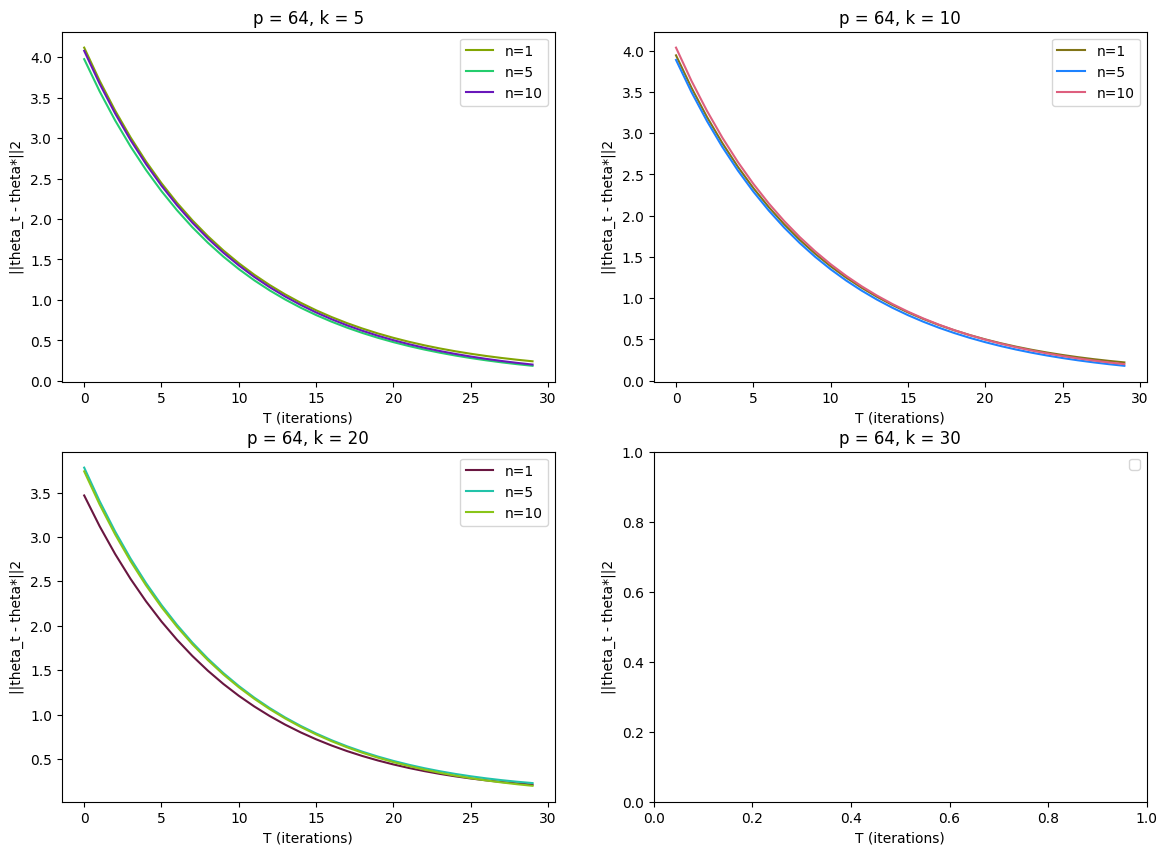

<Figure size 640x480 with 0 Axes>

In [12]:
plot_error_by_iterations(results)

## Plot 2: error by size of n and k

- ox: size of n
- oy: error ||theta_t - theta*||2
- varied by k (sparsity)

In [13]:
n_values = [1, 5, 10, 20]
k_values = [5, 10, 20, 30]
results2 = {}

In [14]:
# Note: didn't do 10 runs here 
for k in k_values:
    for n in n_values:
        eta = 0.1 if n < 3 else 0.2
        iterations = iht_central(int(n * (10 ** 5)), p=64, k=k, T_max=30, eta=eta, c=0.05)

        if not k in results2:
            results2[k] = []
        
        results2[k].append(iterations[-1])
        print(f'n={n}, k={k}, rel_error={iterations[-1]}')

n=1, k=5, rel_error=0.24172899729491043
n=5, k=5, rel_error=0.05277254369901256
n=10, k=5, rel_error=0.04416840697345991
n=20, k=5, rel_error=0.033073943455179146
n=1, k=10, rel_error=0.22223787894237693
n=5, k=10, rel_error=0.048513258245720337
n=10, k=10, rel_error=0.052338241895931975
n=20, k=10, rel_error=0.029076521701374237
n=1, k=20, rel_error=0.2113410581850994
n=5, k=20, rel_error=0.15624081373405088
n=10, k=20, rel_error=0.09124389051649046
n=20, k=20, rel_error=0.14707822940466167
n=1, k=30, rel_error=0.47262932543648006
n=5, k=30, rel_error=0.23476681962140533
n=10, k=30, rel_error=0.2136135368148992
n=20, k=30, rel_error=0.14630778089585675


In [25]:
results2
torch.save(results2, 'plot_2.pt') # key - k; value: last error by n size

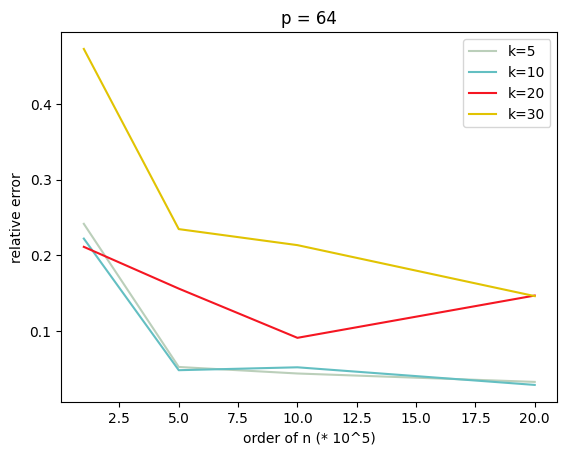

In [15]:
colors = ["darkviolet", "gold", "dodgerblue", "firebrick"]
for k in k_values:
    plt.plot(n_values, results2[k], label=f'k={k}', color=(np.random.random(), np.random.random(), np.random.random()))

plt.legend(loc=1)
plt.xlabel("order of n (* 10^5)")
plt.ylabel("relative error")
plt.title("p = 64")
plt.show()

## Plot 3 - error by n and p

- ox: size of n
- oy: error ||theta_t - theta*||2
- varied by p (dimensionality)

In [17]:
n_values = [1, 5, 10, 20]
p_values = [16, 64, 128, 256]
results3 = {}

In [19]:
# Note: didn't do 10 runs here 
for p in p_values:
    for n in n_values:
        iterations = iht_central(int(n * (10 ** 5)), p=p, k=10, T_max=30, eta=0.1, c=0.05)

        if not p in results3:
            results3[p] = []
        
        results3[p].append(iterations[-1])
        print(f'n={n}, p={p}, rel_error={iterations[-1]}')

n=1, p=16, rel_error=0.1288937514647168
n=5, p=16, rel_error=0.524077935581599
n=10, p=16, rel_error=0.4031991983546441
n=20, p=16, rel_error=0.03554539115835592
n=1, p=64, rel_error=0.22223787894237693
n=5, p=64, rel_error=0.18089203004615792
n=10, p=64, rel_error=0.20126389740969855
n=20, p=64, rel_error=0.18167382029290882
n=1, p=128, rel_error=0.28425980647744836
n=5, p=128, rel_error=0.2885751982359785
n=10, p=128, rel_error=0.2721599330259548
n=20, p=128, rel_error=0.27210104412757546
n=1, p=256, rel_error=0.5412700176951928
n=5, p=256, rel_error=0.4154917996463191
n=10, p=256, rel_error=0.4011797420584301
n=20, p=256, rel_error=0.3781265599886246


In [28]:
results3
torch.save(results3, 'plot_3.pt') # key - p; value: last error by size n

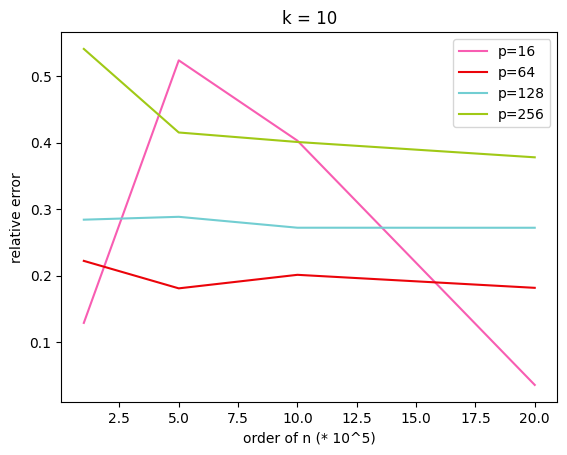

In [21]:
colors = ["darkviolet", "gold", "dodgerblue", "firebrick"]
for p in p_values:
    plt.plot(n_values, results3[p], label=f'p={p}', color=(np.random.random(), np.random.random(), np.random.random()))

plt.legend(loc=1)
plt.xlabel("order of n (* 10^5)")
plt.ylabel("relative error")
plt.title("k = 10")
plt.show()